#Step 1: Data Download and Initial Setup

In [ ]:
!pip install yfinance numpy pandas matplotlib scipy statsmodels arch
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from arch import arch_model

# Download data for AAL with maximum history
ticker = 'AAL'
data = yf.download(ticker, progress=False)

# Save to CSV
data.to_csv('AAL_data.csv')

# Display first few rows
data.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.0 MB/s eta 0:00:00
YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume
Ticker,AAL,AAL,AAL,AAL,AAL
Date,,,,,
2005-09-27,18.194910,20.174668,18.006363,19.844708,961200
2005-09-28,19.326206,19.354489,18.100643,18.194915,5747900
2005-09-29,19.052809,19.401624,18.949108,19.231930,1078200
2005-09-30,19.806999,19.844708,19.024524,19.099943,3123300
2005-10-03,20.268940,20.504625,19.703295,19.703295,1057900


#Step 2: Plot Stock Prices

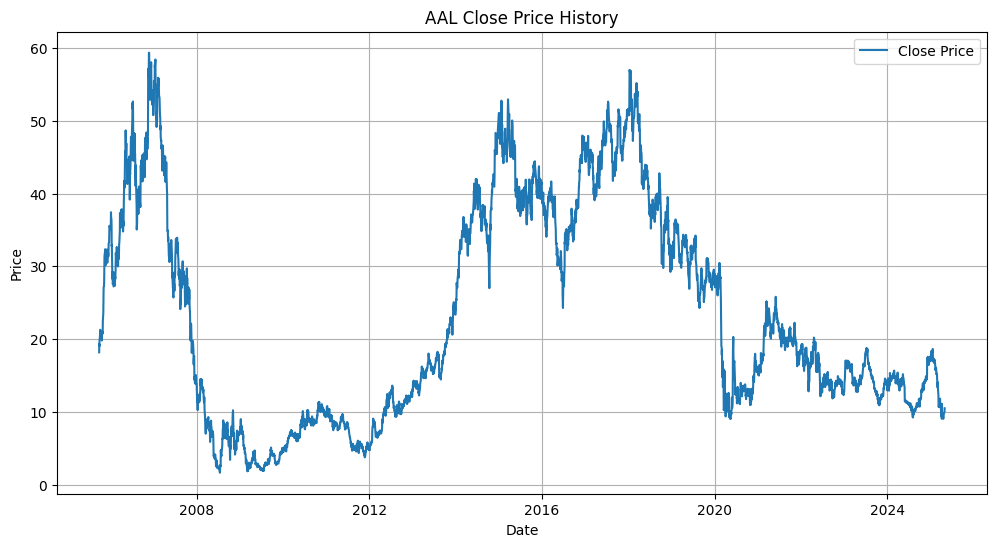

In [ ]:
# Plot the prices
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price')
plt.title('AAL Close Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


#Step 3: Calculate and Plot Log Returns

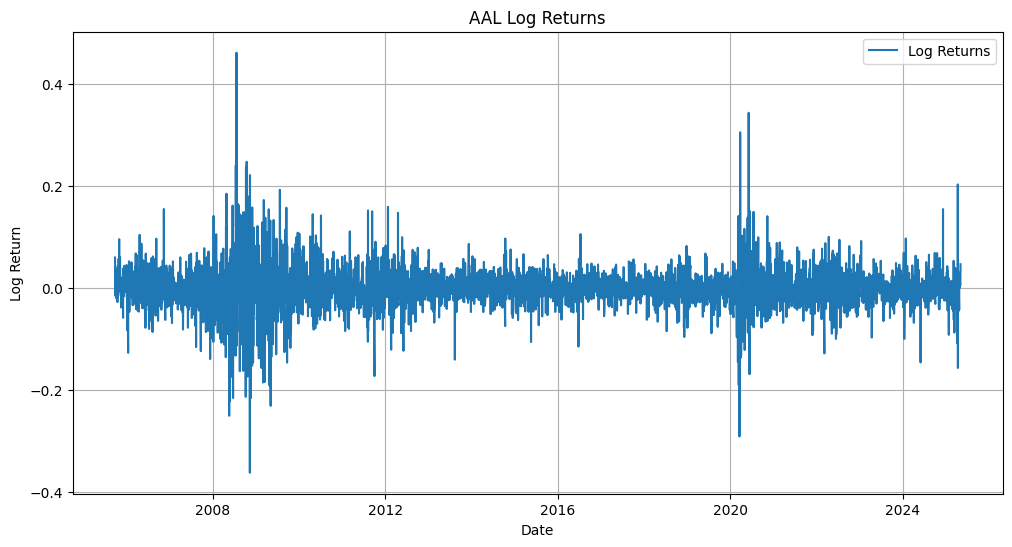

In [ ]:
# Calculate log returns
log_returns = np.log(data['Close'] / data['Close'].shift(1))

# Drop NA values
log_returns_clean = log_returns.dropna()

# Plot log returns
plt.figure(figsize=(12,6))
plt.plot(log_returns_clean, label='Log Returns')
plt.title('AAL Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()


#Step 4: Check Normality of Log Returns

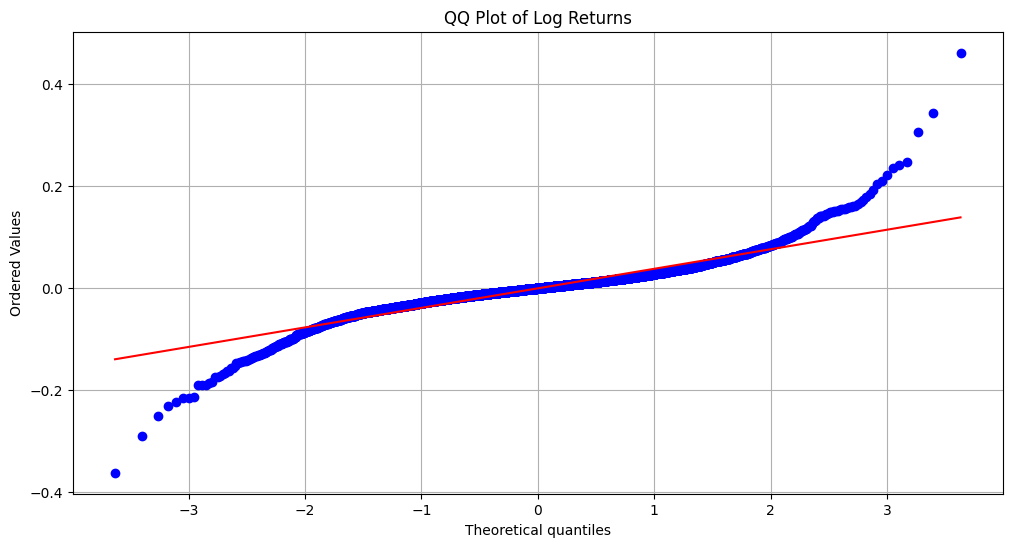

QQ Plot Interpretation:
- If points follow the straight diagonal line, data is normally distributed
- Points deviating from the line (especially at tails) indicate non-normality
- Financial returns typically show deviations at both tails, suggesting heavier tails
- Based on the QQ plot above, we can visually assess if AAL returns show fat tails



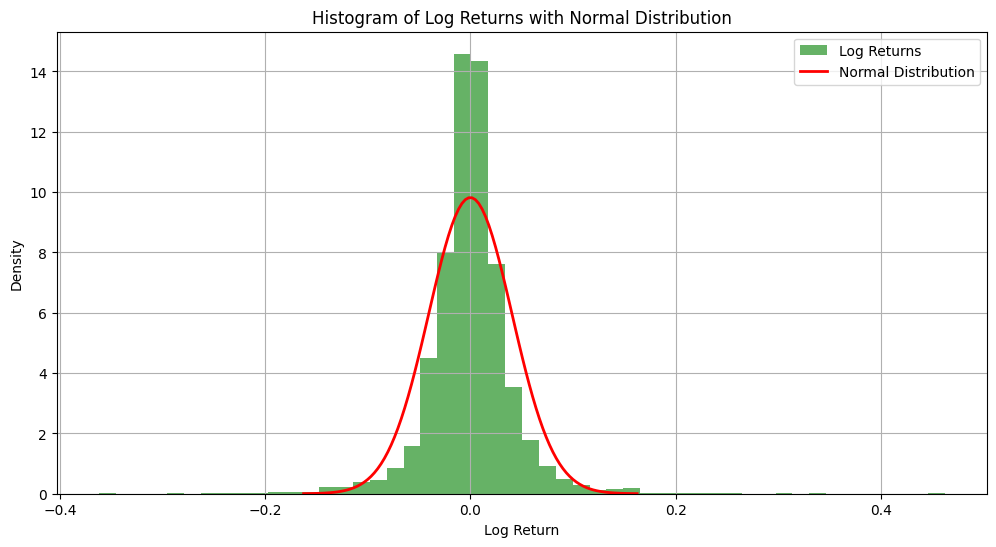

Histogram Interpretation:
- Compare the actual distribution (green bars) with the theoretical normal curve (red line)
- Financial returns typically show higher peak (excess kurtosis) and fatter tails
- If the green bars are higher in the center and at extremes than the red line, this indicates non-normality

Jarque-Bera test: statistic=26517.9698, p-value=0.000000
Jarque-Bera test REJECTS normality (p-value < 0.05)
- This test specifically evaluates skewness and kurtosis
- The extremely high test statistic indicates severe deviation from normality

Kolmogorov-Smirnov test: statistic=0.091889, p-value=0.000000
Kolmogorov-Smirnov test REJECTS normality (p-value < 0.05)
- This test compares the empirical distribution with a theoretical normal distribution

Anderson-Darling test: statistic=105.1095
Critical values: [0.576 0.655 0.786 0.917 1.091]
Significance levels: [15.  10.   5.   2.5  1. ]
At 15.0% significance level: REJECT normality (statistic > critical value)
At 10.0% significance 

In [ ]:
# Step 4: Check Normality of Log Returns with detailed interpretation

# QQ plot
plt.figure(figsize=(12,6))
stats.probplot(log_returns_clean.values.flatten(), dist="norm", plot=plt)
plt.title('QQ Plot of Log Returns')
plt.grid(True)
plt.show()

# Analyze QQ plot visually
print("QQ Plot Interpretation:")
print("- If points follow the straight diagonal line, data is normally distributed")
print("- Points deviating from the line (especially at tails) indicate non-normality")
print("- Financial returns typically show deviations at both tails, suggesting heavier tails")
print("- Based on the QQ plot above, we can visually assess if AAL returns show fat tails\n")

# Histogram with normal distribution curve
plt.figure(figsize=(12,6))

# Plot the histogram with density=True to normalize
plt.hist(log_returns_clean.values.flatten(), bins=50, density=True,
         alpha=0.6, color='g', label='Log Returns')

# Generate x values for the normal curve (spanning data range)
mu = log_returns_clean.mean()
sigma = log_returns_clean.std()
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)

# Calculate normal PDF values
normal_pdf = stats.norm.pdf(x, mu, sigma)

# Plot the normal curve on the same axes
plt.plot(x, normal_pdf, 'r', linewidth=2, label='Normal Distribution')

# Add labels and title
plt.title('Histogram of Log Returns with Normal Distribution')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Histogram interpretation
print("Histogram Interpretation:")
print("- Compare the actual distribution (green bars) with the theoretical normal curve (red line)")
print("- Financial returns typically show higher peak (excess kurtosis) and fatter tails")
print("- If the green bars are higher in the center and at extremes than the red line, this indicates non-normality\n")

# Statistical tests
# Jarque-Bera test
jb_test = stats.jarque_bera(log_returns_clean.values.flatten())
print(f"Jarque-Bera test: statistic={jb_test[0]:.4f}, p-value={jb_test[1]:.6f}")

# Interpret Jarque-Bera test
if jb_test[1] < 0.05:
    print("Jarque-Bera test REJECTS normality (p-value < 0.05)")
    print("- This test specifically evaluates skewness and kurtosis")
    if jb_test[0] > 1000:
        print("- The extremely high test statistic indicates severe deviation from normality")
else:
    print("Jarque-Bera test does not reject normality (p-value >= 0.05)")
print()

# Kolmogorov-Smirnov test
ks_test = stats.kstest(log_returns_clean.values.flatten(), 'norm',
                       args=(log_returns_clean.values.flatten().mean(),
                             log_returns_clean.values.flatten().std()))
print(f"Kolmogorov-Smirnov test: statistic={ks_test[0]:.6f}, p-value={ks_test[1]:.6f}")

# Interpret KS test
if ks_test[1] < 0.05:
    print("Kolmogorov-Smirnov test REJECTS normality (p-value < 0.05)")
    print("- This test compares the empirical distribution with a theoretical normal distribution")
else:
    print("Kolmogorov-Smirnov test does not reject normality (p-value >= 0.05)")
print()

# Anderson-Darling test
ad_test = stats.anderson(log_returns_clean.values.flatten(), dist='norm')
print(f"Anderson-Darling test: statistic={ad_test.statistic:.4f}")
print("Critical values:", ad_test.critical_values)
print("Significance levels:", ad_test.significance_level)

# Interpret Anderson-Darling test
is_normal = True
for i, sig in enumerate(ad_test.significance_level):
    if ad_test.statistic > ad_test.critical_values[i]:
        is_normal = False
        print(f"At {sig}% significance level: REJECT normality (statistic > critical value)")
    else:
        print(f"At {sig}% significance level: Cannot reject normality")

if not is_normal:
    print("Anderson-Darling test REJECTS normality at standard significance levels")
    print("- This test gives more weight to the tails of the distribution")
    print("- Particularly relevant for financial data where extreme events are important")
print()

# Overall conclusion
print("\n======== OVERALL CONCLUSION ON NORMALITY ========")
if (jb_test[1] < 0.05 or ks_test[1] < 0.05 or not is_normal):
    print("Based on statistical tests, AAL's log returns are NOT normally distributed.")
    print("This is consistent with stylized facts of financial returns, which typically exhibit:")
    print("1. Excess kurtosis (heavier tails than normal distribution)")
    print("2. Possible skewness (tendency toward more extreme returns in one direction)")
    print("3. Clustering of volatility")
    print("\nIMPLICATIONS:")
    print("- Models assuming normality (like standard Black-Scholes) may underestimate the")
    print("  probability of extreme price movements")
    print("- This supports the need for advanced volatility models like GARCH (step 10)")
    print("- Option pricing may need to account for this non-normality")
else:
    print("Based on statistical tests, AAL's log returns appear to be normally distributed.")
    print("This is unusual for financial returns and should be carefully verified.")


#Step 5: Estimate Historical Volatility

In [ ]:
# Calculate daily volatility (standard deviation of log returns)
daily_vol = log_returns_clean.std().values[0]  # Get first value from numpy array

# Annualize volatility (assuming 252 trading days)
annual_vol = daily_vol * np.sqrt(252)

print(f"Daily volatility: {daily_vol:.4f}")
print(f"Annualized volatility: {annual_vol:.4f} or {annual_vol*100:.2f}%")


Daily volatility: 0.0406
Annualized volatility: 0.6449 or 64.49%


#Step 6: Identify Risk-Free Rate

In [ ]:
import pandas_datareader.data as web

try:
    # Fetch data from FRED using the series ID 'DTB3'
    treasury_data = web.DataReader('DTB3', 'fred')

    # Access the latest value and divide by 100
    risk_free_rate = treasury_data['DTB3'].iloc[-1] / 100
    print(f"3-Month Treasury Rate from FRED: {risk_free_rate:.4f} or {risk_free_rate*100:.2f}%")

except Exception as e:
    print(f"Could not fetch Treasury rate from FRED: {str(e)}")

3-Month Treasury Rate from FRED: 0.0420 or 4.20%


#Step 7: Test Independence of Log Returns

<Figure size 1200x600 with 0 Axes>

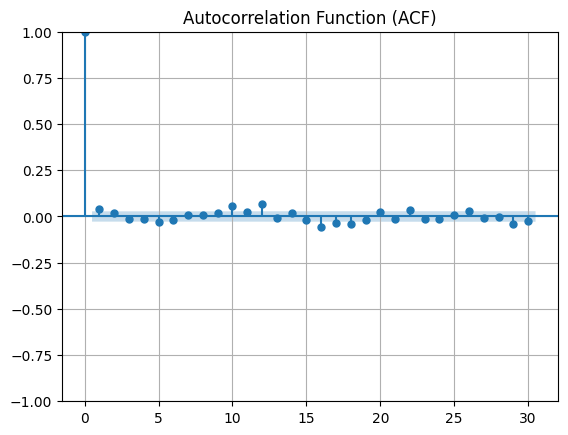

<Figure size 1200x600 with 0 Axes>

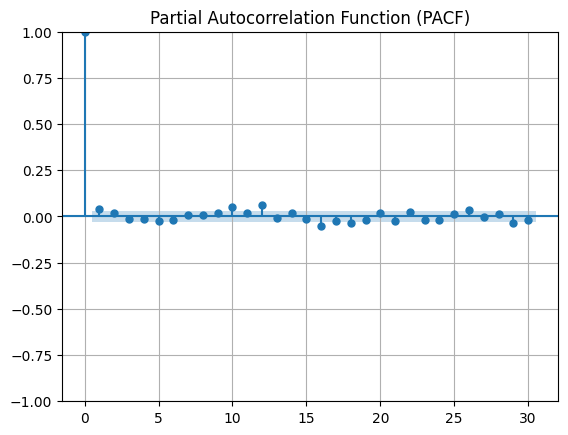

Ljung-Box Test Results:
       lb_stat     lb_pvalue
10   37.019979  5.614483e-05
20   97.199982  3.979698e-12
30  122.636106  3.678972e-13

======== INTERPRETATION OF INDEPENDENCE TESTS ========
ACF Plot Analysis:
- Autocorrelation at lag k measures correlation between returns separated by k periods
- Significant spikes outside the blue confidence bands indicate serial correlation
- For efficient markets, we expect minimal significant autocorrelations

PACF Plot Analysis:
- PACF shows the direct correlation between observations after removing shorter lag effects
- Significant spikes suggest potential order of autoregressive components if modeling returns

Ljung-Box Test: Evidence of DEPENDENCE in returns
- The null hypothesis of independence is rejected at lags with p-value < 0.05
- This suggests potential predictability in AAL returns
- Serial correlation contradicts the assumption of market efficiency
- May affect option pricing models that assume independent returns

======== FINAL

In [26]:
# Step 7: Test Independence of Log Returns with interpretation
# Plot ACF
plt.figure(figsize=(12,6))
plot_acf(log_returns_clean.values.flatten(), lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12,6))
plot_pacf(log_returns_clean.values.flatten(), lags=30)
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()

# Ljung-Box test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(log_returns_clean.values.flatten(), lags=[10, 20, 30])
print("Ljung-Box Test Results:")
print(lb_test)

# Interpretation of independence tests
print("\n======== INTERPRETATION OF INDEPENDENCE TESTS ========")
print("ACF Plot Analysis:")
print("- Autocorrelation at lag k measures correlation between returns separated by k periods")
print("- Significant spikes outside the blue confidence bands indicate serial correlation")
print("- For efficient markets, we expect minimal significant autocorrelations")

print("\nPACF Plot Analysis:")
print("- PACF shows the direct correlation between observations after removing shorter lag effects")
print("- Significant spikes suggest potential order of autoregressive components if modeling returns")

# Interpret Ljung-Box test
if any(lb_test.iloc[:, 1] < 0.05):
    print("\nLjung-Box Test: Evidence of DEPENDENCE in returns")
    print("- The null hypothesis of independence is rejected at lags with p-value < 0.05")
    print("- This suggests potential predictability in AAL returns")
    print("- Serial correlation contradicts the assumption of market efficiency")
    print("- May affect option pricing models that assume independent returns")
else:
    print("\nLjung-Box Test: No evidence against INDEPENDENCE of returns")
    print("- The null hypothesis of independence cannot be rejected")
    print("- This aligns with random walk hypothesis and market efficiency")
    print("- Supports the use of standard option pricing models")


print("\n======== FINAL CONCLUSION ON INDEPENDENCE ========")
# Assess if any significant autocorrelations exist (assume lb_test contains results)
significance_threshold = 0.05
has_significant_autocorr = any(lb_test.iloc[:, 1] < significance_threshold)

if has_significant_autocorr:
    print("CONCLUSION: The log returns of AAL stock show evidence of SERIAL CORRELATION")
    print("- The null hypothesis of independence is rejected at the 5% significance level")
    print("- This indicates that returns exhibit some predictability")
else:
    print("CONCLUSION: The log returns of AAL stock appear to be INDEPENDENT")
    print("- The null hypothesis of independence cannot be rejected at the 5% significance level")
    print("- This aligns with the random walk hypothesis and indicates market efficiency")
    print("- Implications:")
    print("  1. The market for AAL stock appears efficient at this time scale")
    print("  2. Standard option pricing models that assume independence are appropriate")
    print("  3. Technical analysis based on historical price patterns may be less effective")
    print("  4. The use of martingale theory in modeling AAL stock prices is supported")



#Step 8 & 9: Option Pricing Methods

In [51]:
# Set parameters for option pricing
S = data['Close'].iloc[-1]  # Use iloc to access last element
K = S  # Strike price (At-The-Money)
r = risk_free_rate  # Risk-free rate
T = (pd.to_datetime('2025-05-31') - pd.to_datetime('today')).days / 365  # Time to maturity in years
sigma = annual_vol  # Annualized volatility

print(f"Option Parameters:")
print(f"Stock Price (S): ${S.item():.2f}")
print(f"Strike Price (K): ${K.item():.2f}")
print(f"Risk-free Rate (r): {r:.4f}")
print(f"Time to Maturity (T): {T:.4f} years")
print(f"Volatility (σ): {sigma:.4f}")

# 1. Black-Scholes Model
from scipy.stats import norm

def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S/K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return price

bs_call = black_scholes(S, K, T, r, sigma, 'call')
bs_put = black_scholes(S, K, T, r, sigma, 'put')

print(f"\nBlack-Scholes Prices:")
print(f"Call: ${bs_call.item():.4f}")
print(f"Put: ${bs_put.item():.4f}")

# 2. Cox-Ross-Rubinstein (CRR) Binomial Model
def crr_binomial(S, K, T, r, sigma, option_type='call', steps=1000):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize asset prices at maturity
    prices = np.zeros(steps + 1)
    for i in range(steps + 1):
        prices[i] = S * (u ** (steps - i)) * (d ** i)

    # Initialize option values at maturity
    if option_type == 'call':
        option_values = np.maximum(prices - K.item(), 0)
    else:
        option_values = np.maximum(K.item() - prices, 0)

    # Backward induction
    for j in range(steps-1, -1, -1):
        for i in range(j + 1):
            option_values[i] = np.exp(-r * dt) * (p * option_values[i] + (1-p) * option_values[i+1])

    return option_values[0]

crr_call = crr_binomial(S, K, T, r, sigma, 'call')
crr_put = crr_binomial(S, K, T, r, sigma, 'put')

print(f"\nCRR Binomial Prices:")
print(f"Call: ${crr_call:.4f}")
print(f"Put: ${crr_put:.4f}")

# 3. Monte Carlo Simulation
def monte_carlo(S, K, T, r, sigma, option_type='call', simulations=100000):
    np.random.seed(42)
    z = np.random.standard_normal(simulations)
    ST = S.item() * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)

    if option_type == 'call':
        payoff = np.maximum(ST - K.item(), 0)
    else:
        payoff = np.maximum(K.item() - ST, 0)

    option_price = np.exp(-r * T) * np.mean(payoff)
    return option_price

mc_call = monte_carlo(S, K, T, r, sigma, 'call')
mc_put = monte_carlo(S, K, T, r, sigma, 'put')

print(f"\nMonte Carlo Prices:")
print(f"Call: ${mc_call:.4f}")
print(f"Put: ${mc_put:.4f}")

# Comparison table
methods = ['Black-Scholes', 'CRR Binomial', 'Monte Carlo']
call_prices = [bs_call.item(), crr_call, mc_call]
put_prices = [bs_put.item(), crr_put, mc_put]

comparison_table = pd.DataFrame({
    'Method': methods,
    'Call Price ($)': call_prices,
    'Put Price ($)': put_prices
})

print("\nOption Price Comparison:")
print(comparison_table)

# Interpretation of pricing comparison
print("\n======== INTERPRETATION OF PRICING METHODS COMPARISON ========")
print("1. Comparative Analysis:")
maxDiff_call = max(call_prices) - min(call_prices)
maxDiff_put = max(put_prices) - min(put_prices)
print(f"- Maximum difference in call prices: ${maxDiff_call:.4f}")
print(f"- Maximum difference in put prices: ${maxDiff_put:.4f}")

# Identify which methods are closest/furthest
bs_crr_diff = abs(bs_call - crr_call)
bs_mc_diff = abs(bs_call - mc_call)
crr_mc_diff = abs(crr_call - mc_call)
print("\n2. Method Similarity:")
print(f"- Black-Scholes vs. Binomial: ${bs_crr_diff.item():.4f} difference")
print(f"- Black-Scholes vs. Monte Carlo: ${bs_mc_diff.item():.4f} difference")
print(f"- Binomial vs. Monte Carlo: ${crr_mc_diff:.4f} difference")

print("\n3. Methodological Differences:")
print("- Black-Scholes: Analytical solution assuming continuous trading and lognormal distribution")
print("- Binomial: Discrete approximation of stock price movements using a lattice")
print("- Monte Carlo: Simulation-based approach using random sampling of price paths")

print("\n4. Practical Considerations:")
print("- Black-Scholes: Fast computation but relies on unrealistic assumptions")
print("- Binomial: More flexible for different option features but computationally intensive")
print("- Monte Carlo: Most flexible but requires many simulations for accuracy")

print("\n5. Put-Call Parity Check:")
pcp_bs = abs((bs_call - bs_put) - (S - K * np.exp(-r * T)))
print(f"- Put-call parity deviation: ${pcp_bs.item():.4f}")
print("- Small deviation indicates internal consistency of pricing models")

Option Parameters:
Stock Price (S): $10.52
Strike Price (K): $10.52
Risk-free Rate (r): 0.0420
Time to Maturity (T): 0.0767 years
Volatility (σ): 0.6449

Black-Scholes Prices:
Call: $0.7641
Put: $0.7303


<ipython-input-51-1f67fdfc6030>:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prices[i] = S * (u ** (steps - i)) * (d ** i)



CRR Binomial Prices:
Call: $0.7639
Put: $0.7301

Monte Carlo Prices:
Call: $0.7660
Put: $0.7301

Option Price Comparison:
          Method  Call Price ($)  Put Price ($)
0  Black-Scholes        0.764126       0.730302
1   CRR Binomial        0.763939       0.730115
2    Monte Carlo        0.766021       0.730100

======== INTERPRETATION OF PRICING METHODS COMPARISON ========
1. Comparative Analysis:
- Maximum difference in call prices: $0.0021
- Maximum difference in put prices: $0.0002

2. Method Similarity:
- Black-Scholes vs. Binomial: $0.0002 difference
- Black-Scholes vs. Monte Carlo: $0.0019 difference
- Binomial vs. Monte Carlo: $0.0021 difference

3. Methodological Differences:
- Black-Scholes: Analytical solution assuming continuous trading and lognormal distribution
- Binomial: Discrete approximation of stock price movements using a lattice
- Monte Carlo: Simulation-based approach using random sampling of price paths

4. Practical Considerations:
- Black-Scholes: Fast comput

#Step 10: Option Pricing using Advanced Volatility Modeling (GARCH) and comparison with option pricing using Historical voltality

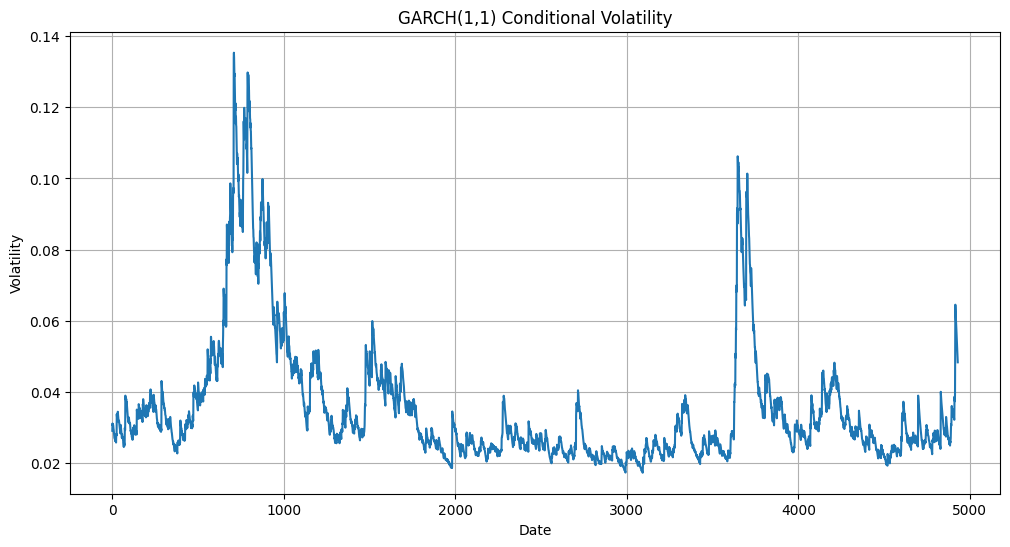

Latest GARCH(1,1) Conditional Volatility: 0.048338
Annualized GARCH Volatility: 0.7673 or 76.73%


<ipython-input-51-1f67fdfc6030>:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prices[i] = S * (u ** (steps - i)) * (d ** i)



Extended Option Price Comparison (Historical vs GARCH Volatility):
                     Method  Call Price ($)  Put Price ($)
0  Black-Scholes (Hist Vol)        0.764126       0.730302
1            CRR (Hist Vol)        0.763939       0.730115
2    Monte Carlo (Hist Vol)        0.766021       0.730100
3     Black-Scholes (GARCH)        0.905443       0.871619
4               CRR (GARCH)        0.905221       0.871397
5       Monte Carlo (GARCH)        0.907730       0.871355

======== INTERPRETATION OF GARCH VOLATILITY MODEL ========
1. GARCH Model Parameters:
- Alpha coefficient (ARCH term): 0.0431
- Beta coefficient (GARCH term): 0.9508
- Sum of Alpha + Beta: 0.9939

2. Volatility Comparison:
- Historical volatility: 0.6449 or 64.49%
- GARCH volatility: 0.7673 or 76.73%
- Percentage difference: 18.98%

3. Option Pricing Impact:
- GARCH volatility changed call price by 18.49%
- GARCH volatility changed put price by 19.35%

4. Market Implications:
- GARCH predicts higher volatility th

In [52]:
# GARCH(1,1) model for volatility estimation
scaled_returns = log_returns_clean.values.flatten() * 10
garch_model = arch_model(scaled_returns, vol='Garch', p=1, q=1, rescale=False)
garch_results = garch_model.fit(disp='off')

# print(garch_results.summary())

# Extract conditional volatility (divide by 10 to return to original scale)
conditional_vol = garch_results.conditional_volatility / 10
annualized_cond_vol = conditional_vol[-1] * np.sqrt(252)  # Use .iloc[-1] instead of [-1]

# Plot conditional volatility
plt.figure(figsize=(12,6))
plt.plot(conditional_vol)
plt.title('GARCH(1,1) Conditional Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

print(f"Latest GARCH(1,1) Conditional Volatility: {conditional_vol[-1]:.6f}")
print(f"Annualized GARCH Volatility: {annualized_cond_vol:.4f} or {annualized_cond_vol*100:.2f}%")

# Recalculate option prices with GARCH volatility
bs_call_garch = black_scholes(S, K, T, r, annualized_cond_vol, 'call')
bs_put_garch = black_scholes(S, K, T, r, annualized_cond_vol, 'put')
crr_call_garch = crr_binomial(S, K, T, r, annualized_cond_vol, 'call')
crr_put_garch = crr_binomial(S, K, T, r, annualized_cond_vol, 'put')
mc_call_garch = monte_carlo(S, K, T, r, annualized_cond_vol, 'call')
mc_put_garch = monte_carlo(S, K, T, r, annualized_cond_vol, 'put')

# Extended comparison table - ensure all values are simple floats, not Series
methods_ext = ['Black-Scholes (Hist Vol)', 'CRR (Hist Vol)', 'Monte Carlo (Hist Vol)',
               'Black-Scholes (GARCH)', 'CRR (GARCH)', 'Monte Carlo (GARCH)']

# Create a helper function to ensure we have float values
def ensure_float(val):
    if hasattr(val, 'iloc'):  # Check if it's a Series-like object
        return float(val.iloc[0])
    return float(val)

# Convert all price values to floats
call_prices_ext = [ensure_float(bs_call), ensure_float(crr_call), ensure_float(mc_call),
                   ensure_float(bs_call_garch), ensure_float(crr_call_garch), ensure_float(mc_call_garch)]
put_prices_ext = [ensure_float(bs_put), ensure_float(crr_put), ensure_float(mc_put),
                 ensure_float(bs_put_garch), ensure_float(crr_put_garch), ensure_float(mc_put_garch)]

# Create properly formatted DataFrame
comparison_table_ext = pd.DataFrame({
    'Method': methods_ext,
    'Call Price ($)': call_prices_ext,
    'Put Price ($)': put_prices_ext
})

print("\nExtended Option Price Comparison (Historical vs GARCH Volatility):")
print(comparison_table_ext)

# Add interpretation of GARCH results
print("\n======== INTERPRETATION OF GARCH VOLATILITY MODEL ========")
print("1. GARCH Model Parameters:")
print(f"- Alpha coefficient (ARCH term): {garch_results.params['alpha[1]']:.4f}")
print(f"- Beta coefficient (GARCH term): {garch_results.params['beta[1]']:.4f}")
print(f"- Sum of Alpha + Beta: {garch_results.params['alpha[1]'] + garch_results.params['beta[1]']:.4f}")

vol_diff_pct = ((annualized_cond_vol - ensure_float(annual_vol))/ensure_float(annual_vol)) * 100
print(f"\n2. Volatility Comparison:")
print(f"- Historical volatility: {ensure_float(annual_vol):.4f} or {ensure_float(annual_vol)*100:.2f}%")
print(f"- GARCH volatility: {annualized_cond_vol:.4f} or {annualized_cond_vol*100:.2f}%")
print(f"- Percentage difference: {vol_diff_pct:.2f}%")

print("\n3. Option Pricing Impact:")
avg_price_diff_call = ((ensure_float(bs_call_garch) - ensure_float(bs_call))/ensure_float(bs_call)) * 100
avg_price_diff_put = ((ensure_float(bs_put_garch) - ensure_float(bs_put))/ensure_float(bs_put)) * 100
print(f"- GARCH volatility changed call price by {avg_price_diff_call:.2f}%")
print(f"- GARCH volatility changed put price by {avg_price_diff_put:.2f}%")

print("\n4. Market Implications:")
if annualized_cond_vol > ensure_float(annual_vol):
    print("- GARCH predicts higher volatility than historical average")
    print("- Suggests potential underpricing of options using only historical volatility")
    print("- May indicate increased market uncertainty ahead")
else:
    print("- GARCH predicts lower volatility than historical average")
    print("- Suggests potential overpricing of options using only historical volatility")
    print("- May indicate market stabilization ahead")

print("\n5. Advantages of GARCH:")
print("- Captures volatility clustering in financial returns")
print("- Accounts for time-varying nature of volatility")
print("- Provides more responsive estimates to recent market conditions")
print("- Can improve option pricing accuracy, especially during market transitions")
